In [57]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

#------------------------------------------ Create Merge DF -----------------------------------------------------------

short_names = ['MIA', 'LAR', 'KAN', 'TAM', 'PHI', 'BAL', 'GNB', 'LVR', 'HOU', 'BUF', 'DET', 'IND', 
               'MIN', 'NOR', 'NYG', 'WAS', 'DAL', 'SEA', 'CLE', 'CIN', 'JAX', 'ARI', 'CAR', 'PIT', 
               'ATL', 'LAC', 'DEN', 'TEN', 'NWE', 'CHI','NYJ','SFO']

# Correctly matched full names
full_names = ['Miami Dolphins', 'Los Angeles Rams', 'Kansas City Chiefs', 'Tampa Bay Buccaneers', 
              'Philadelphia Eagles', 'Baltimore Ravens', 'Green Bay Packers', 'Las Vegas Raiders', 
              'Houston Texans', 'Buffalo Bills', 'Detroit Lions', 'Indianapolis Colts', 
              'Minnesota Vikings', 'New Orleans Saints', 'New York Giants', 'Washington Commanders', 
              'Dallas Cowboys', 'Seattle Seahawks', 'Cleveland Browns', 'Cincinnati Bengals', 
              'Jacksonville Jaguars', 'Arizona Cardinals', 'Carolina Panthers', 'Pittsburgh Steelers', 
              'Atlanta Falcons', 'Los Angeles Chargers', 'Denver Broncos', 'Tennessee Titans', 
              'New England Patriots', 'Chicago Bears','New York Jets','San Francisco 49ers']

AFC = ['MIA', 'KAN', 'BAL', 'LVR', 'HOU', 'BUF', 'IND', 'CLE', 'CIN', 
             'JAX', 'PIT', 'LAC', 'DEN', 'TEN', 'NWE','NYJ']
NFC = ['LAR', 'TAM', 'PHI', 'GNB', 'DET', 'MIN', 'NOR', 'NYG', 'WAS', 
             'DAL', 'SEA', 'ARI', 'CAR', 'ATL', 'CHI','SFO']

Divisions = {
    'AFC East': ['MIA', 'BUF', 'NWE', 'NYJ'],
    'AFC North': ['BAL', 'CIN', 'CLE', 'PIT'],
    'AFC South': ['HOU', 'IND', 'JAX', 'TEN'],
    'AFC West': ['KAN', 'LVR', 'LAC', 'DEN'],
    
    'NFC East': ['DAL', 'NYG', 'PHI', 'WAS'],
    'NFC North': ['GNB', 'CHI', 'DET', 'MIN'],
    'NFC South': ['TAM', 'NOR', 'ATL', 'CAR'],
    'NFC West': ['LAR', 'SEA', 'ARI', 'SFO']
}


# Create the DataFrame
df = pd.DataFrame({'Short Name': short_names, 'Full Name': full_names})

# ----------------------------------------- Create QB Data Table ------------------------------------------------------------

# Get the page content
url = 'https://www.pro-football-reference.com/years/2024/passing.htm'
response = requests.get(url)
page_content = response.content

# Parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find the table
table = soup.find('table', {'id': 'passing'})

# Convert the table to a pandas DataFrame
passes = pd.read_html(str(table))[0]

#clean data to contain relevant values and remove unnecessary rows
passes = passes[passes.Pos == 'QB'].reset_index(drop=True)
pass_f = passes[passes['Player'] != 'League Average']

#rename QB columns so they are unique to position
pass_f.rename(columns = {'Yds':'Pass Yards','TD':'Pass TD','Att':'Pass Attempts','1D':'Passing 1D','Y/A':'Pass Yards/Att','Lng':'Pass (Lng)'},inplace=True)
pass_f.drop(columns = ['Succ%','TD%','Int%'],inplace=True)


pass_f['Sk%'] = pass_f['Sk%'] / 100
pass_f['Cmp%'] = pass_f['Cmp%'] / 100


# --------------------------------------------- Create RB Data Table ----------------------------------------------------------

# Get the page content
url = 'https://www.pro-football-reference.com/years/2024/rushing.htm'
response = requests.get(url)
page_content = response.content

# Parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find and remove the <tr> tag with the class 'over header'
for tr in soup.find_all('tr', {'class': 'over_header'}):
    tr.decompose()  # Remove the <tr> element from the soup

# Find the table
table = soup.find('table', {'id': 'rushing'})

# Convert the cleaned table to a pandas DataFrame
rush = pd.read_html(str(table), header=0)[0]

rush['Yds'] = pd.to_numeric(rush['Yds'], errors='coerce').fillna(0).astype('int64')

#rename RB columns so they are unique to position
rush.rename(columns = {'Tm':'Team','Att':'Rush Att','Yds':'Rush Yards','TD':'Rush TD','1D':'Rushing 1D','Y/A':'Rush Yards/Att','Y/G':'Rush Yards/Game','Lng':'Rush (Lng)','Fmb':'RB Fumble'},inplace=True)

rush.drop(columns = ['Succ%'],inplace=True)


#---------------------------------------------- Create WR Data Table -------------------------------------------------------

# Get the page content
url = 'https://www.pro-football-reference.com/years/2024/receiving.htm'
response = requests.get(url)
page_content = response.content

# Parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find and remove the <tr> tag with the class 'over header'
for tr in soup.find_all('tr', {'class': 'over_header'}):
    tr.decompose()  # Remove the <tr> element from the soup

# Find the table
table = soup.find('table', {'id': 'receiving'})
# Convert the cleaned table to a pandas DataFrame
rec = pd.read_html(str(table), header=0)[0]

#clean data to contain relevant values and remove unnecessary rows
rec = rec[rec['Player'] != 'Player']
rec = rec[rec.Rec != '0'].reset_index(drop=True)

rec['Yds'] = pd.to_numeric(rec['Yds'], errors='coerce').fillna(0).astype('int64')
rec['Y/G'] = pd.to_numeric(rec['Y/G'], errors='coerce').fillna(0).astype('float')

#convert necessary columns to float to calculate YAC
rec['Y/R'] = pd.to_numeric(rec['Y/R'])
rec['Y/Tgt'] = pd.to_numeric(rec['Y/Tgt'])
rec['Yards after Catch'] = rec['Y/R'] - rec['Y/Tgt']

#rename WR columns so they are unique to WR
rec.rename(columns = {'Tm':'Team','Yds':'Receiving Yards','TD':'Receiving TD','1D':'Receiving 1D','Y/A':'Receiving Yards/Att','Y/G':'Receiving Yards/Game','Lng':'Receiving (Lng)','Fmb':'WR Fumble'},inplace=True)

rec.drop(columns = ['Succ%','Ctch%'],inplace=True)


# ---------------------------------------------- Create Defense Data Table ------------------------------------------------


# Get the page content
url = 'https://www.pro-football-reference.com/years/2024/defense.htm'
response = requests.get(url)
page_content = response.content

# Parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find and remove the <tr> tag with the class 'over header'
for tr in soup.find_all('tr', {'class': 'over_header'}):
    tr.decompose()  # Remove the <tr> element from the soup

# Find the table
table = soup.find('table', {'id': 'defense'})


# Convert the cleaned table to a pandas DataFrame
defense = pd.read_html(str(table), header=0)[0]

#remove unwanted rows

i = defense[defense.Player == 'Player'].index
defense = defense.drop(i)

defense.rename(columns = {'Tm':'Team'},inplace=True)

defense['Comb'] = pd.to_numeric(defense['Comb'], errors='coerce').fillna(0).astype('int64')
#replace NaN with 0
defense = defense.replace(np.nan,0)

#drop unnecessary columns

defense.drop(columns = ['Rk'],inplace=True)


# ------------------------------ Add full team name, division, and conference data to position tables -------------------------
pass_f = pd.merge(pass_f, df, left_on='Team', right_on='Short Name', how='left')
rush = pd.merge(rush, df, left_on='Team', right_on='Short Name', how='left')
rec = pd.merge(rec, df, left_on='Team', right_on='Short Name', how='left')
defense = pd.merge(defense, df, left_on='Team', right_on='Short Name', how='left')

for i in [pass_f, rush, rec, defense]:
    
    for index, row in i.iterrows():
        for division, teams in Divisions.items():
            if row['Team'] in teams:
                i.loc[index, 'Division'] = division
    
    i['Conference'] = i['Short Name'].apply(lambda x: 'AFC' if x in AFC else 'NFC')

    

    i.drop(columns=['Short Name'], inplace=True)


#Print tables
print("Passing Data below:")
display(pass_f.head())
print("Rushing Data below:")
display(rush.head())
print("Receiving Data below:")
display(rec.head())
print("Defensive Data below:")
display(defense.head())
# ---------------------------------- Combine offensive data into one table ----------------------------------------------------

offense = pd.concat([pass_f,rush,rec],ignore_index = True)

#Split QB Record column into W/L/T columns

offense[['Win', 'Loss', 'Tie']] = offense['QBrec'].str.split('-', expand=True)

#Replace NAN with 0

offense = offense.replace(np.nan,0)

#drop unnecessary columns

offense.drop(columns = ['Rk','Age','Awards'],inplace=True)

print("Offensive Data below:")
display(offense.head())


# ---------------------------------------- get standings/result data ----------------------------------------------------------

# Get the page content
url = 'https://www.pro-football-reference.com/years/2024/games.htm'
response = requests.get(url)
page_content = response.content

# Parse the HTML content
soup = BeautifulSoup(page_content, 'html.parser')

# Find and remove the <tr> tag with the class 'over header'
for tr in soup.find_all('tr', {'class': 'over_header'}):
    tr.decompose()  # Remove the <tr> element from the soup

# Find the table
table = soup.find('table', {'id': 'games'})

# Convert the cleaned table to a pandas DataFrame
standings = pd.read_html(str(table), header=0)[0]
standings = standings.drop(columns = {"Unnamed: 7",'Unnamed: 5'})

i = standings[standings.Date == 'Date'].index
standings = standings.drop(i)

#Add in month column
standings['Date'] = pd.to_datetime(standings['Date'])
standings['Month'] = standings.Date.dt.month
standings['Day'] = standings['Date'].dt.strftime('%A')
standings['Time'] = pd.to_datetime(standings['Time'], format='%I:%M%p').dt.strftime('%I:%M%p')

#update week dtype to prep for merge

standings['Week'] = standings.Week.astype('int64')

#replace NaN with 0

standings = standings.replace(np.nan,0)
# Output the cleaned data

print('Schedule Data below:')
display(standings.head())


# ------------------------------------------------------ get schedule data ----------------------------------------------------

import nfl_data_py as nfl
schedule = nfl.import_schedules([2024]).reset_index(drop=True).fillna(0)

#create month column

schedule['gameday'] = pd.to_datetime(schedule['gameday'])
schedule['Month'] = schedule.gameday.dt.month

#clean time formatting

schedule['gametime'] = pd.to_datetime(schedule['gametime'], format='%H:%M')
schedule['gametime'] = schedule['gametime'].dt.strftime('%I:%M %p').str.replace(' ','')

# create column for regular season and postseason
game = ['DIV','CON','SB']
schedule['Regular_Post'] = schedule.game_type.apply(lambda x:'POST' if x in game else 'REG')

# original and new values
original_values = ['BAL', 'GB', 'PIT', 'ARI', 'TEN', 'NE', 'HOU', 'JAX', 'CAR', 'MIN', 'LV', 'DEN', 
                   'DAL', 'WAS', 'LA', 'NYJ', 'BUF', 'LAC', 'NO', 'TB', 'IND', 'CLE', 'SF', 'SEA', 
                   'NYG', 'CIN', 'CHI', 'ATL', 'PHI', 'MIA', 'DET', 'KC']

new_values = ['BAL', 'GNB', 'PIT', 'ARI', 'TEN', 'NWE', 'HOU', 'JAX', 'CAR', 'MIN', 'LVR', 'DEN', 
              'DAL', 'WAS', 'LAR', 'NYJ', 'BUF', 'LAC', 'NOR', 'TAM', 'IND', 'CLE', 'SFO', 'SEA', 
              'NYG', 'CIN', 'CHI', 'ATL', 'PHI', 'MIA', 'DET', 'KAN']

# create a mapping dictionary
rename_mapping = dict(zip(original_values, new_values))


# replace the original values with the new values
schedule['away_team'] = schedule['away_team'].replace(rename_mapping)
schedule['home_team'] = schedule['home_team'].replace(rename_mapping)

#merge schedule with df in first cell to prepare merge with standings df

schedule = pd.merge(schedule,df, left_on ='away_team',right_on = 'Short Name',how = 'left')
schedule = pd.merge(schedule,df, left_on ='home_team',right_on = 'Short Name',how = 'left')

#create column for winning and losing team

for i in range(len(schedule)):
    if schedule.loc[i,'away_score'] > schedule.loc[i,'home_score']:
        schedule.loc[i,'Winning_Team'] = schedule.loc[i,'Full Name_x']
    else:
        schedule.loc[i,'Winning_Team'] = schedule.loc[i,'Full Name_y']

#drop columns
schedule.rename(columns = {'weekday':'Day','gametime':'Time'},inplace = True)
schedule.drop(columns = ['old_game_id','gsis','nfl_detail_id','pfr','pff','espn','ftn','away_qb_id','home_qb_id','stadium_id'],inplace=True)

print('Schedule Data below:')
display(schedule.head())

# ----------------------------------------- Merge schedule/results tables -----------------------------------------------------

#create list to use for logic in gametime column
dfs = [schedule,standings]

sunday_afternoon = ['01:00PM', '03:00PM','04:25PM','04:30PM','04:15PM','04:05PM']
sunday_night = ['06:30PM','08:20PM','08:15PM','08:00PM']

for i in dfs:

    # Create a new column 'game_name' and initialize it with 'Uncategorized'
    i['game_name'] = 'Uncategorized'

    # Apply conditions for 'Thursday'
    i.loc[i['Day'] == 'Thursday', 'game_name'] = 'Thursday Night'

    # Apply conditions for 'Friday'
    i.loc[i['Day'] == 'Friday', 'game_name'] = 'Friday Night'

    # Apply conditions for 'Monday'
    i.loc[i['Day'] == 'Monday', 'game_name'] = 'Monday Night'

    # Apply conditions for 'Saturday'
    i.loc[i['Day'] == 'Saturday', 'game_name'] = 'Saturday Night'

    # Apply conditions for 'Sunday Afternoon'
    i.loc[(i['Day'] == 'Sunday') & (i['Time'].isin(sunday_afternoon)), 'game_name'] = 'Sunday Afternoon'

    # Apply conditions for 'Sunday Night'
    i.loc[(i['Day'] == 'Sunday') & (i['Time'].isin(sunday_night)), 'game_name'] = 'Sunday Night'
    #apply conditions for 'International'
    i.loc[((i['Day'] == 'Sunday') |(i['Day'] == 'Friday'))& ((i['Time'] == '09:30AM')|(i['Time'] == '08:15PM')), 'game_name'] = 'International'

Schedule = pd.merge(schedule,standings,left_on = ['gameday','Time','Winning_Team'],right_on = ['Date','Time','Winner/tie'],how = 'left')

# -------------------------------------------- Clean Schedule/Results Table --------------------------------------------------

Schedule.rename(columns = {'Day_x':'Day','Winner/tie':'Winning Team','Loser/tie':'Losing Team','Month_x':'Month','game_name_y':'Game Name','Full Name_x':'Full Name Away','Full Name_y':'Full Name Home'},inplace=True)
Schedule.drop(columns = ['game_name_x','Short Name_x','Short Name_y','Winning_Team','Week','Day_y','Date','Time','Month_y'],inplace=True)

#replace misssing data with 0
Schedule = Schedule.replace(np.nan,0)

#Remove games not yet played
Schedule = Schedule[Schedule['Game Name'] != 0].reset_index(drop=True)

#update surface column

for i in range(len(Schedule)):
    if Schedule.loc[i,'roof'] == 'outdoors':
        Schedule.loc[i,'surface'] = 'grass'
    else:
        Schedule.loc[i,'surface'] = 'artificial'

print('Merged Schedule Data below:')
display(Schedule.head())


Passing Data below:


,Rk,Player,Age,Team,Pos,G,GS,QBrec,Cmp,Pass Attempts,Cmp%,Pass Yards,Pass TD,Int,Passing 1D,Pass (Lng),Pass Yards/Att,AY/A,Y/C,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD,Awards,Full Name,Division,Conference
0,1.0,Brock Purdy,25.0,SFO,QB,2.0,2.0,1-1-0,47.0,65.0,0.723,550.0,1.0,1.0,29.0,34.0,8.5,8.08,11.7,275.0,96.3,63.3,8.0,28.0,0.1096,7.15,6.81,0.0,0.0,NaN,San Francisco 49ers,NFC West,NFC
1,2.0,Gardner Minshew II,28.0,LVR,QB,2.0,2.0,1-1-0,55.0,71.0,0.775,533.0,2.0,2.0,26.0,33.0,7.5,6.80,9.7,266.5,95.6,44.1,9.0,75.0,0.1125,5.73,5.10,1.0,1.0,NaN,Las Vegas Raiders,AFC West,AFC
2,3.0,Matthew Stafford,36.0,LAR,QB,2.0,2.0,0-2-0,53.0,76.0,0.697,533.0,1.0,1.0,24.0,63.0,7.0,6.68,10.1,266.5,88.3,49.2,7.0,37.0,0.0843,5.98,5.67,0.0,0.0,NaN,Los Angeles Rams,NFC West,NFC
3,4.0,Jared Goff,30.0,DET,QB,2.0,2.0,1-1-0,52.0,83.0,0.627,524.0,1.0,3.0,22.0,52.0,6.3,4.93,10.1,262.0,69.6,37.4,2.0,17.0,0.0235,5.96,4.61,1.0,1.0,NaN,Detroit Lions,NFC North,NFC
4,5.0,Lamar Jackson,27.0,BAL,QB,2.0,2.0,0-2-0,47.0,75.0,0.627,520.0,2.0,1.0,25.0,49.0,6.9,6.87,11.1,260.0,86.5,55.6,3.0,21.0,0.0385,6.40,6.33,0.0,0.0,NaN,Baltimore Ravens,AFC North,AFC


Rushing Data below:


,Rk,Player,Team,Age,Pos,G,GS,Rush Att,Rush Yards,Rush TD,Rushing 1D,Rush (Lng),Rush Yards/Att,Rush Yards/Game,RB Fumble,Full Name,Division,Conference
0,1,Josh Jacobs,GNB,26,RB,2,2,48,235,0,12,34,4.9,117.5,2,Green Bay Packers,NFC North,NFC
1,2,Jordan Mason,SFO,25,RB,2,2,48,247,2,12,24,5.1,123.5,1,San Francisco 49ers,NFC West,NFC
2,3,Saquon Barkley,PHI,27,RB,2,2,46,204,2,9,34,4.4,102.0,0,Philadelphia Eagles,NFC East,NFC
3,4,Rhamondre Stevenson,NWE,26,RB,2,2,46,201,2,11,18,4.4,100.5,2,New England Patriots,AFC East,AFC
4,5,Joe Mixon,HOU,28,RB,2,2,39,184,1,10,16,4.7,92.0,0,Houston Texans,AFC South,AFC


Receiving Data below:


,Rk,Player,Team,Age,Pos,G,GS,Tgt,Rec,Receiving Yards,Y/R,Receiving TD,Receiving 1D,Receiving (Lng),Y/Tgt,R/G,Receiving Yards/Game,WR Fumble,Yards after Catch,Full Name,Division,Conference
0,1,Cooper Kupp,LAR,31,WR,2,2,27,18,147,8.2,1,7,24,5.4,9.0,73.5,0,2.8,Los Angeles Rams,NFC West,NFC
1,2,Brock Bowers,LVR,22,TE,2,1,17,15,156,10.4,0,8,27,9.2,7.5,78.0,0,1.2,Las Vegas Raiders,AFC West,AFC
2,3,Chris Godwin,TAM,28,WR,2,2,16,15,200,13.3,2,12,41,12.5,7.5,100.0,0,0.8,Tampa Bay Buccaneers,NFC South,NFC
3,4,Malik Nabers,NYG,21,WR,2,2,25,15,193,12.9,1,9,28,7.7,7.5,96.5,0,5.2,New York Giants,NFC East,NFC
4,5,De'Von Achane,MIA,23,RB,2,1,14,14,145,10.4,1,7,39,10.4,7.0,72.5,0,0.0,Miami Dolphins,AFC East,AFC


Defensive Data below:


,Player,Team,Age,Pos,G,GS,Int,Yds,TD,Lng,PD,FF,Fmb,FR,Yds.1,TD.1,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,Full Name,Division,Conference
0,Zack Baun,PHI,28,LB,2,2,0,0,0,0,0,0,0,0,0,0,2.0,24,18,6,1,2,0,Philadelphia Eagles,NFC East,NFC
1,Nick Cross,IND,23,S,2,2,0,0,0,0,0,0,0,0,0,0,0.0,29,18,11,0,0,0,Indianapolis Colts,AFC South,AFC
2,T.J. Edwards,CHI,28,LB,2,2,0,0,0,0,0,0,0,1,0,0,0.0,23,17,6,2,0,0,Chicago Bears,NFC North,NFC
3,Julian Love,SEA,26,FS,2,2,1,0,0,0,2,1,0,0,0,0,0.0,19,17,2,1,0,0,Seattle Seahawks,NFC West,NFC
4,David Long,MIA,28,LB,2,2,0,0,0,0,0,0,0,0,0,0,0.0,19,16,3,2,0,0,Miami Dolphins,AFC East,AFC


Offensive Data below:


,Player,Team,Pos,G,GS,QBrec,Cmp,Pass Attempts,Cmp%,Pass Yards,Pass TD,Int,Passing 1D,Pass (Lng),Pass Yards/Att,AY/A,Y/C,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD,Full Name,Division,Conference,Rush Att,Rush Yards,Rush TD,Rushing 1D,Rush (Lng),Rush Yards/Att,Rush Yards/Game,RB Fumble,Tgt,Rec,Receiving Yards,Y/R,Receiving TD,Receiving 1D,Receiving (Lng),Y/Tgt,R/G,Receiving Yards/Game,WR Fumble,Yards after Catch,Win,Loss,Tie
0,Brock Purdy,SFO,QB,2.0,2.0,1-1-0,47.0,65.0,0.723,550.0,1.0,1.0,29.0,34.0,8.5,8.08,11.7,275.0,96.3,63.3,8.0,28.0,0.1096,7.15,6.81,0.0,0.0,San Francisco 49ers,NFC West,NFC,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0.0,1,1,0
1,Gardner Minshew II,LVR,QB,2.0,2.0,1-1-0,55.0,71.0,0.775,533.0,2.0,2.0,26.0,33.0,7.5,6.80,9.7,266.5,95.6,44.1,9.0,75.0,0.1125,5.73,5.10,1.0,1.0,Las Vegas Raiders,AFC West,AFC,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0.0,1,1,0
2,Matthew Stafford,LAR,QB,2.0,2.0,0-2-0,53.0,76.0,0.697,533.0,1.0,1.0,24.0,63.0,7.0,6.68,10.1,266.5,88.3,49.2,7.0,37.0,0.0843,5.98,5.67,0.0,0.0,Los Angeles Rams,NFC West,NFC,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,2,0
3,Jared Goff,DET,QB,2.0,2.0,1-1-0,52.0,83.0,0.627,524.0,1.0,3.0,22.0,52.0,6.3,4.93,10.1,262.0,69.6,37.4,2.0,17.0,0.0235,5.96,4.61,1.0,1.0,Detroit Lions,NFC North,NFC,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0.0,1,1,0
4,Lamar Jackson,BAL,QB,2.0,2.0,0-2-0,47.0,75.0,0.627,520.0,2.0,1.0,25.0,49.0,6.9,6.87,11.1,260.0,86.5,55.6,3.0,21.0,0.0385,6.40,6.33,0.0,0.0,Baltimore Ravens,AFC North,AFC,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,2,0


Schedule Data below:


,Week,Day,Date,Time,Winner/tie,Loser/tie,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Month
0,1,Thursday,2024-09-05,08:20PM,Kansas City Chiefs,Baltimore Ravens,27,20,353,1,452,1,9
1,1,Friday,2024-09-06,08:15PM,Philadelphia Eagles,Green Bay Packers,34,29,410,3,414,1,9
2,1,Sunday,2024-09-08,01:00PM,Pittsburgh Steelers,Atlanta Falcons,18,10,270,0,226,3,9
3,1,Sunday,2024-09-08,01:00PM,Buffalo Bills,Arizona Cardinals,34,28,352,1,270,1,9
4,1,Sunday,2024-09-08,01:00PM,New Orleans Saints,Carolina Panthers,47,10,379,1,193,3,9


Schedule Data below:


,game_id,season,game_type,week,gameday,Day,Time,away_team,away_score,home_team,home_score,location,result,total,overtime,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium,Month,Regular_Post,Short Name_x,Full Name_x,Short Name_y,Full Name_y,Winning_Team
0,2024_01_BAL_KC,2024,REG,1,2024-09-05,Thursday,08:20PM,BAL,20.0,KAN,27.0,Home,7.0,47.0,0.0,7,7,124.0,-148.0,3.0,-118.0,-102.0,46.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,Lamar Jackson,Patrick Mahomes,John Harbaugh,Andy Reid,Shawn Hochuli,GEHA Field at Arrowhead Stadium,9,REG,BAL,Baltimore Ravens,KAN,Kansas City Chiefs,Kansas City Chiefs
1,2024_01_GB_PHI,2024,REG,1,2024-09-06,Friday,08:15PM,GNB,29.0,PHI,34.0,Neutral,5.0,63.0,0.0,7,7,110.0,-130.0,2.0,-110.0,-110.0,49.5,-112.0,-108.0,0,outdoors,0,0.0,0.0,Jordan Love,Jalen Hurts,Matt LaFleur,Nick Sirianni,Ron Torbert,Arena Corinthians,9,REG,GNB,Green Bay Packers,PHI,Philadelphia Eagles,Philadelphia Eagles
2,2024_01_PIT_ATL,2024,REG,1,2024-09-08,Sunday,01:00PM,PIT,18.0,ATL,10.0,Home,-8.0,28.0,0.0,7,7,160.0,-192.0,4.0,-110.0,-110.0,43.0,-115.0,-105.0,0,closed,fieldturf,0.0,0.0,Justin Fields,Kirk Cousins,Mike Tomlin,Raheem Morris,Brad Rogers,Mercedes-Benz Stadium,9,REG,PIT,Pittsburgh Steelers,ATL,Atlanta Falcons,Pittsburgh Steelers
3,2024_01_ARI_BUF,2024,REG,1,2024-09-08,Sunday,01:00PM,ARI,28.0,BUF,34.0,Home,6.0,62.0,0.0,7,7,250.0,-310.0,6.5,-105.0,-115.0,46.0,-112.0,-108.0,0,outdoors,a_turf,61.0,20.0,Kyler Murray,Josh Allen,Jonathan Gannon,Sean McDermott,Tra Blake,New Era Field,9,REG,ARI,Arizona Cardinals,BUF,Buffalo Bills,Buffalo Bills
4,2024_01_TEN_CHI,2024,REG,1,2024-09-08,Sunday,01:00PM,TEN,17.0,CHI,24.0,Home,7.0,41.0,0.0,7,7,164.0,-198.0,4.0,-108.0,-112.0,43.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,Will Levis,Caleb Williams,Brian Callahan,Matt Eberflus,Shawn Smith,Soldier Field,9,REG,TEN,Tennessee Titans,CHI,Chicago Bears,Chicago Bears


Merged Schedule Data below:


,game_id,season,game_type,week,gameday,Day,away_team,away_score,home_team,home_score,location,result,total,overtime,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium,Month,Regular_Post,Full Name Away,Full Name Home,Winning Team,Losing Team,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Game Name
0,2024_01_BAL_KC,2024,REG,1,2024-09-05,Thursday,BAL,20.0,KAN,27.0,Home,7.0,47.0,0.0,7,7,124.0,-148.0,3.0,-118.0,-102.0,46.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,Lamar Jackson,Patrick Mahomes,John Harbaugh,Andy Reid,Shawn Hochuli,GEHA Field at Arrowhead Stadium,9,REG,Baltimore Ravens,Kansas City Chiefs,Kansas City Chiefs,Baltimore Ravens,27,20,353,1,452,1,Thursday Night
1,2024_01_GB_PHI,2024,REG,1,2024-09-06,Friday,GNB,29.0,PHI,34.0,Neutral,5.0,63.0,0.0,7,7,110.0,-130.0,2.0,-110.0,-110.0,49.5,-112.0,-108.0,0,outdoors,grass,0.0,0.0,Jordan Love,Jalen Hurts,Matt LaFleur,Nick Sirianni,Ron Torbert,Arena Corinthians,9,REG,Green Bay Packers,Philadelphia Eagles,Philadelphia Eagles,Green Bay Packers,34,29,410,3,414,1,International
2,2024_01_PIT_ATL,2024,REG,1,2024-09-08,Sunday,PIT,18.0,ATL,10.0,Home,-8.0,28.0,0.0,7,7,160.0,-192.0,4.0,-110.0,-110.0,43.0,-115.0,-105.0,0,closed,artificial,0.0,0.0,Justin Fields,Kirk Cousins,Mike Tomlin,Raheem Morris,Brad Rogers,Mercedes-Benz Stadium,9,REG,Pittsburgh Steelers,Atlanta Falcons,Pittsburgh Steelers,Atlanta Falcons,18,10,270,0,226,3,Sunday Afternoon
3,2024_01_ARI_BUF,2024,REG,1,2024-09-08,Sunday,ARI,28.0,BUF,34.0,Home,6.0,62.0,0.0,7,7,250.0,-310.0,6.5,-105.0,-115.0,46.0,-112.0,-108.0,0,outdoors,grass,61.0,20.0,Kyler Murray,Josh Allen,Jonathan Gannon,Sean McDermott,Tra Blake,New Era Field,9,REG,Arizona Cardinals,Buffalo Bills,Buffalo Bills,Arizona Cardinals,34,28,352,1,270,1,Sunday Afternoon
4,2024_01_TEN_CHI,2024,REG,1,2024-09-08,Sunday,TEN,17.0,CHI,24.0,Home,7.0,41.0,0.0,7,7,164.0,-198.0,4.0,-108.0,-112.0,43.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,Will Levis,Caleb Williams,Brian Callahan,Matt Eberflus,Shawn Smith,Soldier Field,9,REG,Tennessee Titans,Chicago Bears,Chicago Bears,Tennessee Titans,24,17,148,1,244,3,Sunday Afternoon


In [64]:
# division_count = pass_f.Division.nunique()
# x = range(division_count)
DPass = pass_f.groupby(['Division','Full Name']).agg({'Pass Yards':'sum'}).reset_index()
display(DPass.head())

DRush = rush.groupby(['Division','Full Name']).agg({'Rush Yards':'sum'}).reset_index()
display(DRush.head())

DRec = rec.groupby(['Division','Full Name']).agg({'Y/Tgt':'mean'}).reset_index()
display(DRec.head())

DTackles = defense.groupby(['Division','Full Name']).agg({'Comb':'sum'}).reset_index()
display(DTackles.head())

,Division,Full Name,Pass Yards
0,AFC East,Buffalo Bills,371.0
1,AFC East,Miami Dolphins,563.0
2,AFC East,New England Patriots,270.0
3,AFC East,New York Jets,379.0
4,AFC North,Baltimore Ravens,520.0


,Division,Full Name,Rush Yards
0,AFC East,Buffalo Bills,238
1,AFC East,Miami Dolphins,220
2,AFC East,New England Patriots,355
3,AFC East,New York Jets,169
4,AFC North,Baltimore Ravens,336


,Division,Full Name,Y/Tgt
0,AFC East,Buffalo Bills,8.820000
1,AFC East,Miami Dolphins,6.130000
2,AFC East,New England Patriots,5.700000
3,AFC East,New York Jets,7.785714
4,AFC North,Baltimore Ravens,6.725000


,Division,Full Name,Comb
0,AFC East,Buffalo Bills,134
1,AFC East,Miami Dolphins,100
2,AFC East,New England Patriots,129
3,AFC East,New York Jets,138
4,AFC North,Baltimore Ravens,121


<Axes: xlabel='Division', ylabel='Comb'>

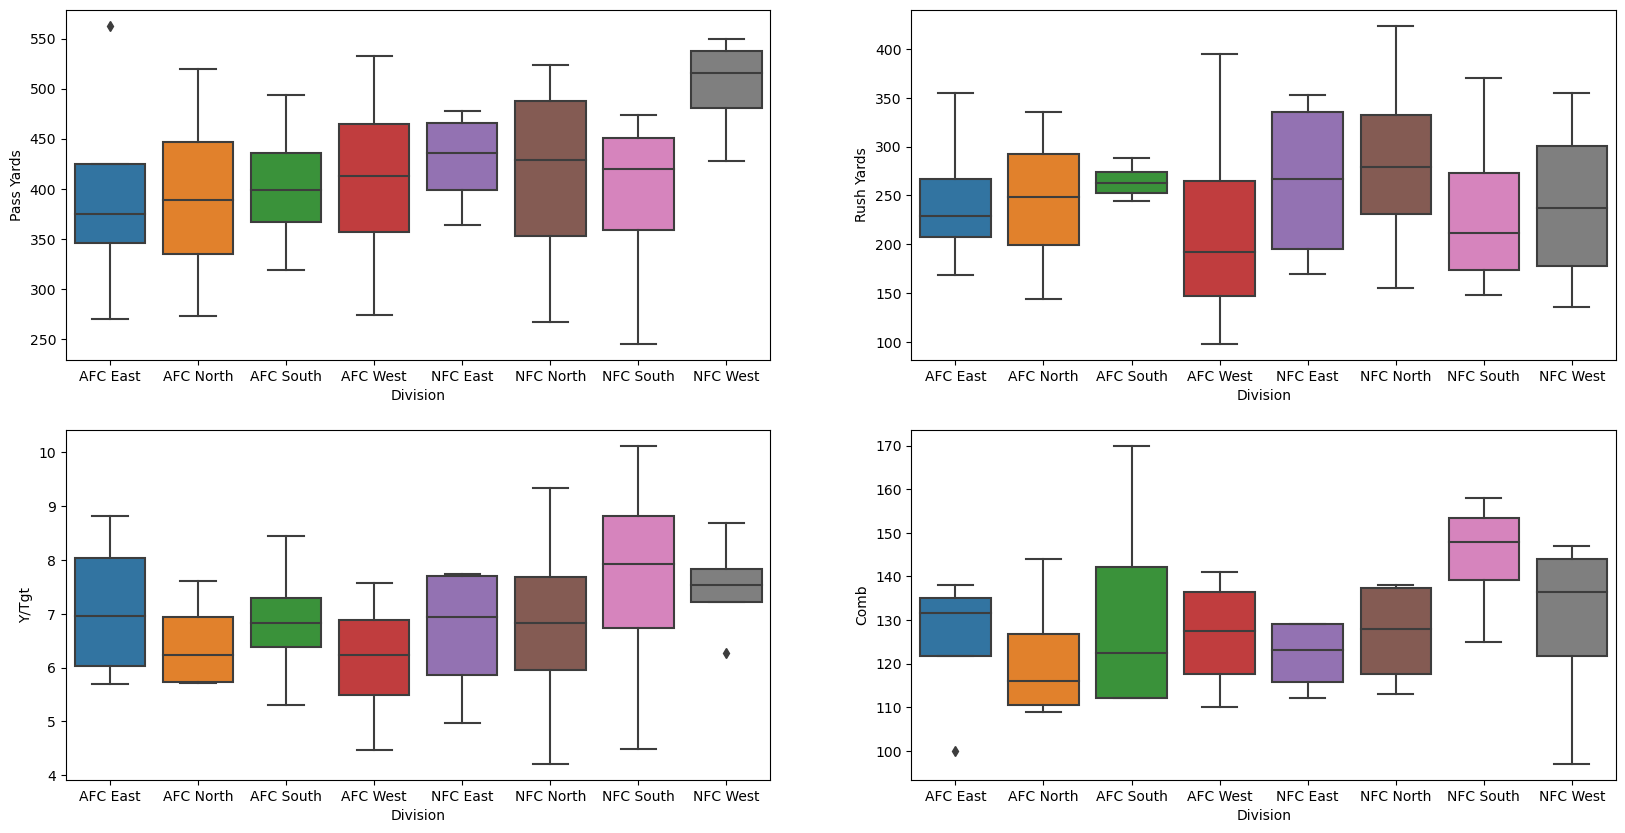

In [65]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.boxplot(x= 'Division', y='Pass Yards',data=DPass)
plt.subplot(2,2,2)
sns.boxplot(x= 'Division', y='Rush Yards',data=DRush)
plt.subplot(2,2,3)
sns.boxplot(x= 'Division', y='Y/Tgt',data=DRec)
plt.subplot(2,2,4)
sns.boxplot(x= 'Division', y='Comb',data=DTackles)
